In [1]:
#if on collab:
from google.colab import drive
drive.mount('/content/drive')

#replace by the parh to ipeo project in the drive
%cd '/content/drive/Othercomputers/My MacBook Pro/ipeo_project'




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Othercomputers/My MacBook Pro/ipeo_project


In [3]:
#!pip install -r requirements.txt
from tqdm import tqdm
import subprocess
from PIL import Image
import numpy as np
import rasterio as rio

from utils import *
from unet_whole_model import *
from dataset import *

%matplotlib inline
%load_ext autoreload
%autoreload 2


##### Observe the full images
We load train & test data, rebuild the full images using the merge_raster.py file and save them.

In [4]:
file_path = "glaciers_mapping_downsampled"
data_paths = {}

#build paths for each pipeline
for pipeline in ["train", "test"]:
    for date in [0,1]:
        data_paths[f"{pipeline}_date{date}"] = f"{file_path}/{pipeline}/date{date}"
    data_paths[f"{pipeline}_gt"] = f"{file_path}/{pipeline}/gt"

In [ ]:
#reconstruct full images
for key, path in tqdm(data_paths.items()):
    output_path = f"{file_path}/{key}_merged.tif"
    # Execute the command to merge rasters using subprocess and save them
    command = ["python", "glaciers_mapping_downsampled/merge_rasters.py", "-i", path, "-o", output_path]
    subprocess.run(command)

100%|██████████| 6/6 [06:25<00:00, 64.27s/it]


Then we save the RGB images in png to be able to observe them and (maybe) draw useful conclusions

In [ ]:
for key in tqdm(data_paths.keys()):
    img_path = f"{file_path}/{key}_merged"
    img = rio.open(f"{img_path}.tif").read()
    if '_gt' in key:
        rgb_image = (img).astype(np.uint8).squeeze(0) * 255
        pil_image = Image.fromarray(rgb_image) #blck and white image
    else:
        rgb_image = (img[:3]*255).astype(np.uint8).transpose(1, 2, 0)
        pil_image = Image.fromarray(rgb_image)
    save_path = f"full_rgb_images/{key}.png"
    pil_image.save(save_path)

100%|██████████| 6/6 [00:54<00:00,  9.01s/it]


### Loading all patches

We store the patches in pytorch datasets :
{
'x' : (position_x_of_patch,
'y' : position_y_of_patch),
'patches' : torch_tensor_of_the_patch
'augmentation' : kind of augmentation performed to get this image, currently none
}

At this stage the tensor of each patch has dimension (band, pixel_x, pixel_y) i.e. (4,128,128) for images and (1,128,128) for groundtruths

In [5]:
all_data = {key : load_paths_data(path) for key, path in data_paths.items()}

Loading data: 100%|██████████| 351/351 [00:00<00:00, 106983.56it/s]


In [6]:
train0_dataset = PatchesDataset(all_data['train_date0'], all_data['train_gt'], 'train0')
train1_dataset = PatchesDataset(all_data['train_date1'], all_data['train_gt'], 'tain1')
test0_dataset = PatchesDataset(all_data['test_date0'], all_data['test_gt'], 'test0')
test1_dataset = PatchesDataset(all_data['test_date1'], all_data['test_gt'], 'test1')

100%|██████████| 351/351 [00:03<00:00, 95.71it/s] 


### Preprocessing

The preprocessing consist in the 0 mean & unit variance normalization channel-wise. It is implemented by the dataset before passing the image to the model.

### First Naive Training with no augmentation

In [ ]:
modelname1 = "no_augmentation_model"
lr = 8e-4
n_epochs = 15
no_augmentation_model = Model(modelname1, lr = lr)
no_augmentation_model.train(train0_dataset, num_epochs= n_epochs)
no_augmentation_model.plot_history()

In [26]:
test_records = {}
test_records = fill_test_record(test_records,
                 modelname1,
                 no_augmentation_model,
                 'train0',
                  [train1_dataset, test0_dataset, test1_dataset])
print(test_records)

100%|██████████| 6/6 [00:01<00:00,  3.91it/s]

{'no_augmentation_model': {'train0': {'best_epoch': 15, 'f1': 0.9622832519114501, 'accuracy': 0.9664226028154481}, 'train1': {'f1': 0.8713063218779759, 'accuracy': 0.8734346277573529}, 'test0': {'f1': 0.9316413992494715, 'accuracy': 0.9321122128739316}, 'test1': {'f1': 0.8804299822681529, 'accuracy': 0.8719898017383368}}}


### Data Augmentation

In [15]:
train0_dataset_augmented = PatchesDataset(all_data['train_date0'], all_data['train_gt'], 'train0_augmented')
train0_dataset_augmented.augment()
train1_dataset_augmented = PatchesDataset(all_data['train_date1'], all_data['train_gt'], 'train1_augmented')
train1_dataset_augmented.augment()

100%|██████████| 12376/12376 [01:46<00:00, 116.45it/s]


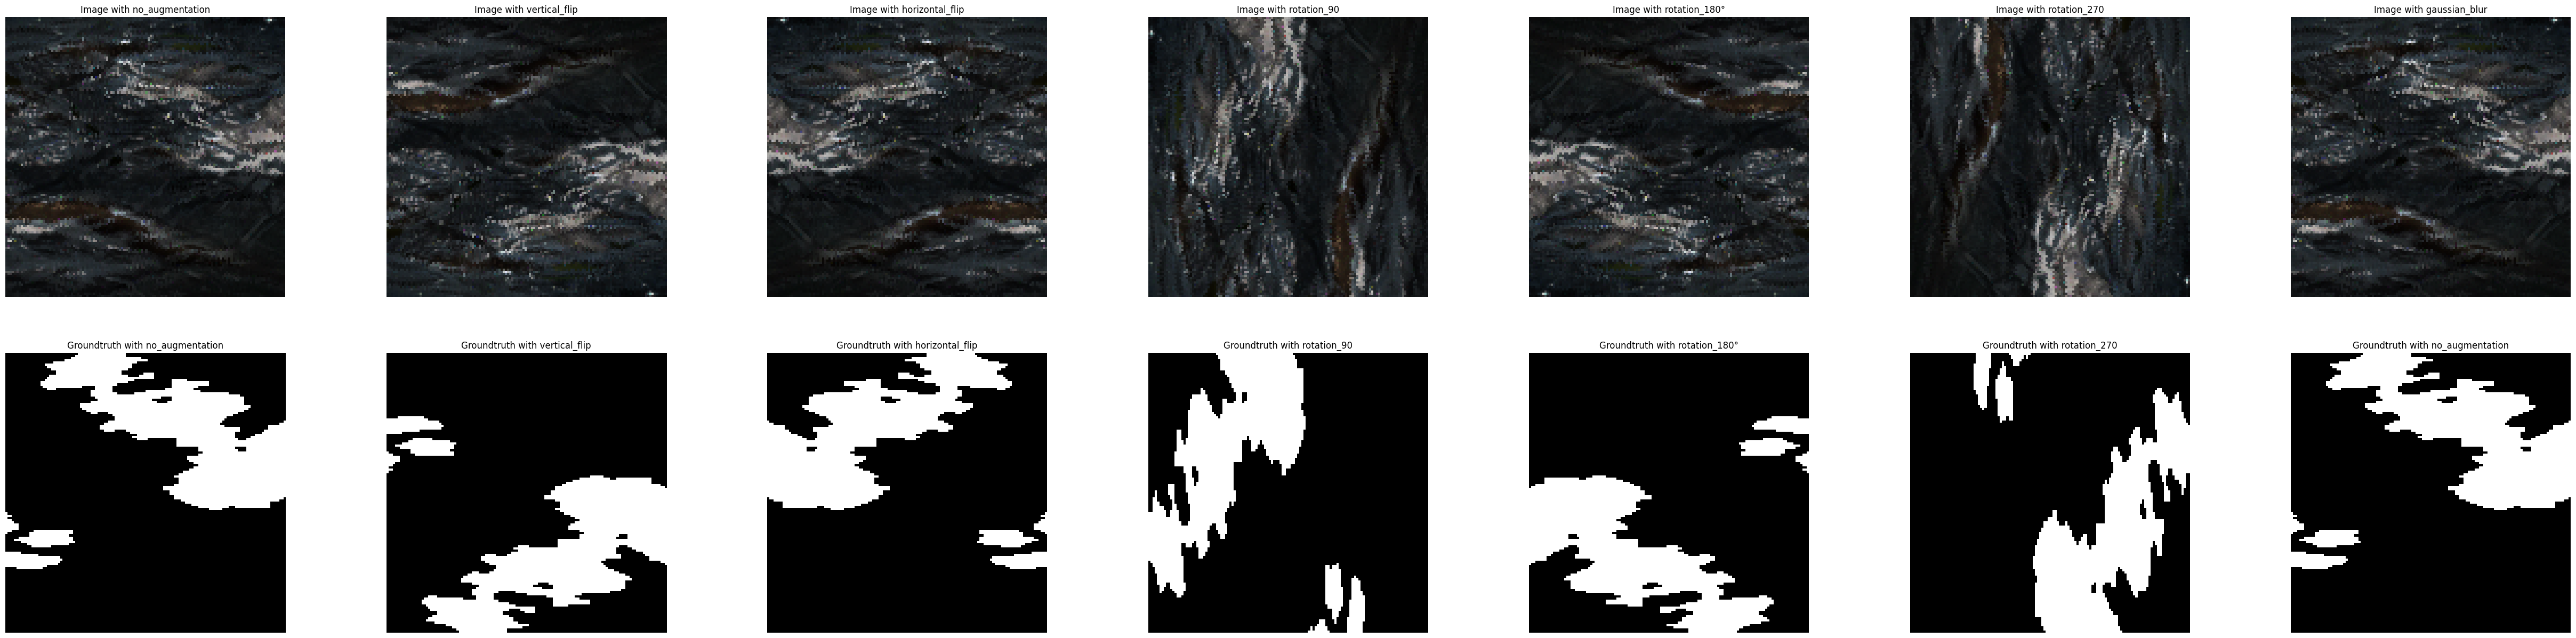

In [21]:
pos_x_ex = 3
pos_y_ex = 9

train0_dataset_augmented.plot_at_pos(pos_x_ex, pos_y_ex)

### Training with augmented data at one date

In [ ]:
modelname2 = 'augmented_mode0'
augmented_model0 = Model(modelname2, lr = lr)
augmented_model0.train(train0_dataset_augmented,num_epochs= n_epochs)
augmented_model0.plot_history()

In [ ]:
test_records = fill_test_record(
                test_records,
                modelname2,
                augmented_model0,
                'train0_augmented',
                [train1_dataset, test0_dataset, test1_dataset])
print(test_records)

In [ ]:
modelname3 = 'augmented_model1'
augmented_model1 = Model(modelname3, lr = lr)
augmented_model1.train(train1_dataset_augmented,num_epochs= n_epochs)
augmented_model1.plot_history()

In [ ]:
test_records = fill_test_record(
                test_records,
                modelname3,
                augmented_model1,
                'train1_augmented',
                [train0_dataset, test0_dataset, test1_dataset])
print(test_records)

### Training with augmented data at both dates

In [ ]:
train0_and_1_dataset_augmented = PatchesDataset([all_data['train_date0'] + all_data['train_date1']],
                                                [all_data['train_gt'] + all_data['train_gt']])
train0_and_1_dataset_augmented.augment()

In [ ]:
modelname4 = 'augmented_model_both'
model_both = Model(modelname4, lr = lr)
model_both.train(train0_and_1_dataset_augmented,num_epochs= n_epochs)
model_both.plot_history()

In [ ]:
test_records = fill_test_record(
                test_records,
                modelname4,
                model_both,
                'both_dates_augmented',
                [test0_dataset, test1_dataset])
print(test_records)